<a href="https://colab.research.google.com/github/anna-danielle/anna-danielle/blob/main/Anna_Danielle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this exercise, I demonstrate my knowledge of classification using datasets provided by researchers published by NCBI who aimed to determine therapeutic targets for liver cancer using whole exome sequencing of individuals with hepatocellular carcinoma. Using LazyPredict, I will also determine which classification method is the best to use for the given dataset. Research Link:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5680778/

#Package Importing and Data Loading

In [ ]:
#Important the necessary packages.
import pandas as pd
import numpy as np
!pip install scikit-learn==0.24 -q
!pip install lazypredict

#Packages for Standard Classification
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Packages for SVC
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC 
from sklearn.preprocessing import scale 
import warnings

#Packages for ROC curves
from sklearn.preprocessing import label_binarize 
from sklearn.metrics import roc_curve, auc 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn import utils

#Packages for visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#Packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Packages for Lazy Predict
import time 
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier, LazyRegressor

#loading the liver gene dataframe, denoted Liver for liver genes
Liver= pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC_RSEM_42cases.txt',sep='\t',header=(0))

#loading the clinical data, denoted clinical
clinical = pd.read_csv('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/LIHC-clinical_data.csv',header=(0))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
clinical

,Barcode,Country,Sample Type,Batch,normal sample for exome analysis (blood=10; adj. normal tissue=11),normal adjacent tissue sample profiled for mRNA expression,Broad GCC - \ncopy number,UNC \nRNA-seq,Methylation,BCGSC- \nmiRNA,...,Baylor GCC whole genome seq,Status,time_of_follow-up,viral_hepatitis_serology,race,gender,pathologic_stage,ObesityClass1,history_hepato_carcinoma_risk_factor,HCC subtypes
0,TCGA-ES-A2HS-01A,United States,Primary solid Tumor,173,TCGA-ES-A2HS-11A,NaN,1,1,1,1.00,...,1,Dead,688,[Not Available],WHITE,MALE,Stage I,Overweight,No History of Primary Risk Factors,NaN
1,TCGA-DD-A3A0-01A,United States,Primary solid Tumor,203,TCGA-DD-A3A0-11A,NaN,1,N/A - RNA depleted,1,1.00,...,NaN,Dead,785,Hepatitis B Surface Antigen|HBV Surface Antibo...,WHITE,MALE,Stage I,Overweight,No History of Primary Risk Factors,No specific subtype
2,TCGA-DD-A73E-01A,United States,Primary solid Tumor,327,TCGA-DD-A73E-10A,NaN,1,1,1,1.00,...,NaN,Alive,1429,Hepatitis B Surface Antigen|HBV Surface Antibody,WHITE,MALE,Stage I,Obese,Alcohol consumption|Non-Alcoholic Fatty Liver ...,No specific subtype
3,TCGA-DD-A1EC-01A,United States,Primary solid Tumor,100,TCGA-DD-A1EC-11A,TCGA-DD-A1EC-11A,1,1,1,1.00,...,NaN,Dead,998,[Unknown],WHITE,FEMALE,Stage I,Normal,[Not Available],Fibrolamellar carcinoma
4,TCGA-G3-A3CI-01A,Canada,Primary solid Tumor,203,TCGA-G3-A3CI-10A,NaN,1,1,1,1.00,...,NaN,Alive,180,[Not Available],WHITE,MALE,Stage I,Obese,Non-Alcoholic Fatty Liver Disease,Steatohepatitic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,TCGA-CC-A7IH-01A,Vietnam,Primary solid Tumor,341,TCGA-CC-A7IH-10A,NaN,1,1,1,1.00,...,NaN,Alive,365,Hepatitis C Antibody|Hepatitis B Surface Antigen,ASIAN,MALE,Stage IIIA,Normal,Alcohol consumption,Clear cell hepatocellular carcinoma
192,TCGA-CC-A7II-01A,Vietnam,Primary solid Tumor,341,TCGA-CC-A7II-10A,NaN,1,1,1,1.00,...,NaN,Alive,399,Hepatitis C Antibody|Hepatitis B Surface Antigen,ASIAN,MALE,Stage IIIA,Normal,Alcohol consumption,No specific subtype
193,TCGA-CC-A7IJ-01A,Vietnam,Primary solid Tumor,345,TCGA-CC-A7IJ-10A,NaN,1,1,1,1.00,...,NaN,Alive,382,Hepatitis C Antibody|Hepatitis B Surface Antigen,ASIAN,MALE,Stage II,Normal,Alcohol consumption,Sarcomatoid hepatocellular carcinoma
194,TCGA-CC-A7IK-01A,Vietnam,Primary solid Tumor,345,TCGA-CC-A7IK-10A,NaN,1,1,1,1.00,...,NaN,Dead,262,Hepatitis C Antibody|Hepatitis B Surface Antigen,ASIAN,MALE,Stage IIIA,Normal,Alcohol consumption,No specific subtype


We must prepare the 2 dataframes to be combined for classification.

In [ ]:
#preparing the Liver gene data
Liver.index = Liver.ID
Liver = Liver.drop(columns=['ID'])
features = Liver.iloc[1:, 0].values
LiverT = np.transpose(Liver)

#preparing the clinical data
clinical['ID'] = clinical.Barcode
clinical.index = clinical.Barcode

#We will choose to classify by Obesity Class. 
clin1 = clinical[['ObesityClass1','ID']]
clin1['ID'] = clin1['ID'].str.replace('-','_') 
clin1

#Now we will combine the clinical data with the genomic data.We will call the new data frame Patient_Profile.
Patient_Profile= pd.merge(LiverT, clin1, left_index=True, right_on='ID').drop(columns='ID')
Patient_Profile.head()

,a100130426,a100133144,a100134869,a10357,a10431,a136542,a155060,a26823,a280660,a317712,...,ZXDB158586,ZXDC79364,ZYG11A440590,ZYG11B79699,ZYX7791,ZZEF123140,ZZZ326009,psiTPTE22387590,tAKR389932,ObesityClass1
Barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-DD-A1EC-01A,0.00,9.20,8.80,144.00,2545.00,0.00,253.00,0.00,0.00,0.00,...,1196.00,1635.00,2.00,2220.00,12725.00,4548.00,1494.00,8.00,1.00,Normal
TCGA-ES-A2HT-01A,0.00,0.00,3.00,104.55,2044.00,0.00,54.00,0.00,0.00,0.00,...,470.00,690.00,8.00,490.00,5090.00,963.00,271.00,4.00,33.00,Overweight
TCGA-DD-A3A8-01A,0.00,2.00,0.00,196.73,1579.00,0.00,161.00,0.00,0.00,0.00,...,251.00,1039.00,41.00,1930.00,1877.00,836.00,547.00,1.00,206.00,Obese
TCGA-DD-A1EL-01A,0.00,8.00,5.00,614.74,4455.00,0.00,437.00,1.00,0.00,0.00,...,815.00,2717.00,110.00,2877.00,3098.00,2076.00,1780.00,14.00,247.00,Normal
TCGA-DD-A3A3-01A,0.00,3.15,1.85,54.87,1069.00,0.00,113.00,0.00,0.00,0.00,...,212.00,627.00,7.00,554.00,2584.00,182.00,284.00,0.00,8.00,Overweight


In [ ]:
#Let's classify the patients according to their weight.

In [ ]:
Patient_Profile.ObesityClass1.value_counts()

Normal        14
Overweight    11
---           10
Obese          7
Name: ObesityClass1, dtype: int64

#SVM

SVM is a method of classification for which. To use the features method, we will use a linear kernel which is reccommend for text classification of data with many features.  

In [ ]:
X = Patient_Profile.iloc[:,:-1].values
y = Patient_Profile.iloc[:, -1].values
classes = np.unique(y)
n_classes = len(classes)
str(classes)

warnings.filterwarnings('ignore')

X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)




#if we fit the data as is, we will get a continous data error. So we will remove the continous data with the function: fit_transform
model = LinearSVC(C=1.0)
preprocess= preprocessing.LabelEncoder()
y_fit=preprocess.fit_transform(y)
model.fit(X_train, y_train)

# after training we can predict labels for the test samples
predictions = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)
model_accuracy

cm = confusion_matrix(y_test,predictions) 
cr = classification_report(y_test,predictions) 
model_accuracy = accuracy_score(y_test, predictions) 

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)


In [ ]:
model_accuracy


0.3076923076923077

We see here that our test model is not that accurate with a 30.7% accuracy.

In [ ]:
template = 'ggplot2'
test_size =0.5

clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

Our SVM model appears to be somewhat inaccurate as it has an f1-score of 44% of the uncatergorized individuals denoted '---' and a 50% f-1 score for those classified as normal, but no f1 scores for obese or overweight patients. This suggests that our SVM model predictions for classification can not accurately classify those who fall under obese or overweight.

#Random Forest

In [ ]:
X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

modelrf = RandomForestClassifier(n_estimators=500, bootstrap=True, verbose=True)
modelrf.fit(X_train, y_train)

predictions1 = modelrf.predict(X_test)
c_matrix1 = confusion_matrix(y_test,predictions1)

CM_df = pd.DataFrame(c_matrix1, columns=classes, index=classes)

cr1 = classification_report(y_test,predictions1, output_dict=True)
model_accuracy1 = accuracy_score(y_test, predictions1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


In [ ]:
model_accuracy1

0.09523809523809523

Our model accuracy for our Random Forest is very, very low with an accuracy of about 9.5%.

In [ ]:
clsf_report2 = pd.DataFrame(cr1).transpose()
clsf_report3 = clsf_report2[0:n_classes]

fig = px.bar(clsf_report3, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

The F1-scores for random forest are worse than the SVC model. The model was only correctly able to predict about 17% of normal sample classifications. There are no f1-scores for the obese, overweight, and uncategorized individuals which suggests that the model does correctly classify those 3 categories.

#Lazy Predict

In [ ]:
model3=LazyClassifier(verbose=0,predictions=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

start_time_1=time.time()
model3,predictions=model3.fit(X_train, X_test, y_train, y_test)
end_time_1=time.time()


100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


In [ ]:
fig = px.bar(models_c[['Time Taken', 'F1 Score','Accuracy']], barmode='group', template=template)
fig.update_layout(width=1200, height=700, template=template, title="Classification Report")
fig.show()

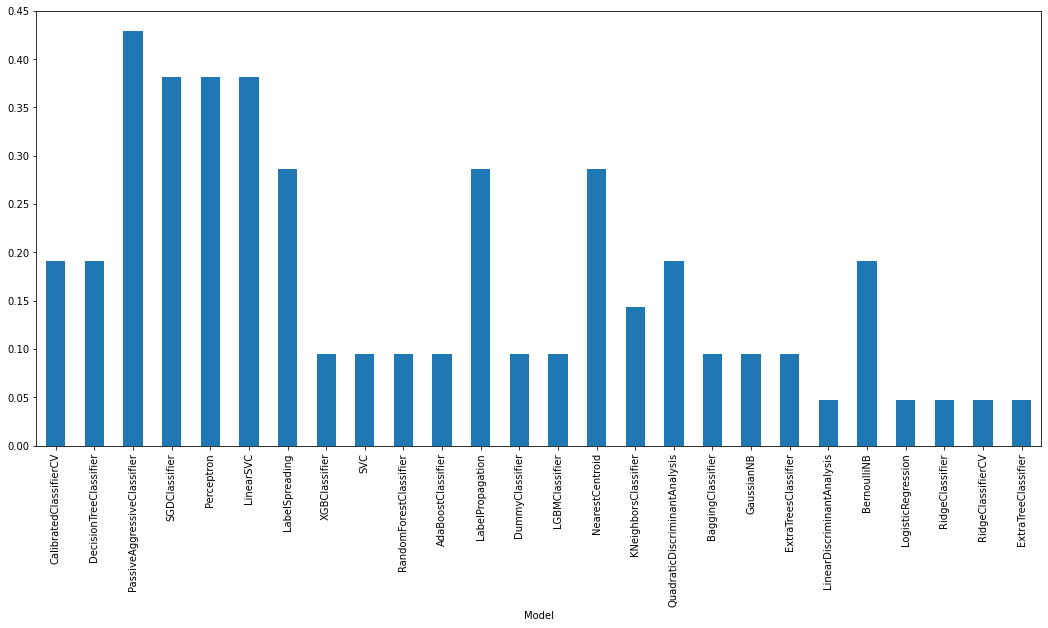

In [ ]:
model3['Accuracy'].plot.bar(figsize = (18,8));

#Confusion Matrix

In [ ]:
#Confusion Matrix for SVC
CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

heat = go.Heatmap(z = CM_df, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix SVC")
fig.show()

In [ ]:
#Confusion Matrix for Random Forest
CM_df1 = pd.DataFrame(c_matrix1, columns=classes, index=classes)

heat = go.Heatmap(z = CM_df1, x=CM_df1.index, 
                  y=CM_df1.columns, 
                  showscale = False,
                  text=CM_df1,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix Random Forest")
fig.show()

#Conclusion

In summary, our classification exercise helps to identify accurate models for classifying our data. Although both of our classification models had low accuracies, the classification method that works the best for our given data is the SVC model with an accuracy score of 30.7%. When classified using Random Forest, the sample shows neighbors. The amount of k-nearest neighbors in a sample can affect which classification model is best. SVC works best with more k-nearest neighbors, while random forest works best with less. Lazy Predict shows no real preference between the two models used in this exercise as they both have f1-scores of 9.52%. It shows that the best classification method is the Passive Aggressive classifier method with an f1- score of 42%, meaning that it correctly predicts about 42% of the classifications in the model. However, 42% is still a relatively low f1-score to have this could be due to the difficulty of correctly classifying the Obese and Overweight observations. The SVC Confusion Matrix shows that 1 individual was correctly classified as obese, the model was unable to correctly classify any overweight individuals, 2 individuals were correctly classified as normal, and 2 individuals were correctly classified as uncatergorized denoted by "---". The Random Forest confusion matrix shows that all of the Obese, uncategorized, and Overweight individuals were actually classified as normal, and only 2 individuals were classified as normal that were actually in the normal weight range. This backs up the bar graph as no f1-scores were available for the obes, uncategorized, and overweight individuals. Perhaps,  a greater number of k-nearest neighbors proved to be more helpful in the SVC model which may suggest that if there were more individuals in the sample data,then the SVC classification model may be more accurate. However, because of difficulty of correctly classifying Obese or Overweight individuals, the accuracy may not improve with the addition of more individuals or data to categorize. 